In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
import requests
import pickle
import re
import os
import cv2

2022-12-08 22:07:11.951641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


In [2]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/960_512/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/960_512/masks_resized_track/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

In [3]:
# pixel labels for each class
tram_track=3 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18
veg = 8

# Prepare the mask label containing 5 labels related to tracks

- tram image from tram_filenames.csv (list prepared by Aras)
- Input images and Masks -> resized (NN) 960x512 , Median filter
- Prepare Binary Masks for all 5 options of labels related to track identification

In [6]:
image_dataset_resized = []
masked_dataset_resized = []

down_width = 960
down_height = 512
down_points = (down_width, down_height)

for i in range(len(tram_list)):
    image_tram = cv2.imread(path_images+tram_dict['filename_jpg'][i],1)
    mask_tram =  cv2.imread(path_masks+tram_dict['filename_mask'][i],0)
    # Median filter 3x3 and resizing 960x512 (NN Interpolation) (such that the dimensions are divisible by 32 becuase of model requiremnet)
    image_tram = cv2.medianBlur(image_tram, 3)
    image_resized= cv2.resize(image_tram, down_points, interpolation= cv2.INTER_NEAREST)

    #cv2.imwrite(path_images_resized+tram_dict['filename_jpg'][i]+'.jpg', image_resized)
    image_dataset_resized.append(image_resized)

    #repeat for masks
    mask_tram=cv2.medianBlur(mask_tram, 3)
    mask_resized= cv2.resize(mask_tram, down_points, interpolation= cv2.INTER_NEAREST)
 
    # Binary masks for track
    for k,val in enumerate(mask_resized):
        for j,val1 in enumerate(val):
            if (val1==tram_track or val1== rail_track or val1==rail_embedded or val1==rail_raised or val1== track_bed):
                val[j] = 1
            else:
                val[j] = 0
    
    masked_dataset_resized.append(mask_resized)
    #cv2.imwrite(path_masks_resized+tram_dict['filename_mask'][i]+'.png', mask_resized)

image_dataset_resized = np.array(image_dataset_resized)
masked_dataset_resized = np.array(masked_dataset_resized)

pickle.dump(image_dataset_resized, open('saved_images/image_dataset_resized_track', "wb"))
pickle.dump(masked_dataset_resized, open('saved_masks/mask_dataset_resized_track', "wb"))

print(image_resized.shape)
print(mask_resized.shape)
print(image_dataset_resized.shape)
print(masked_dataset_resized.shape)

(512, 960, 3)
(512, 960)
(1318, 512, 960, 3)
(1318, 512, 960)


## Load the image_dataset (y) and the mask_dataset (X) via pickle

In [7]:
image_dataset_resized= pickle.load(open("saved_images/image_dataset_resized_track", "rb"))
masked_dataset_resized = pickle.load(open("saved_masks/mask_dataset_resized_track", "rb"))

## expand dim of prepared mask due to model requiremnet 

In [8]:
print(masked_dataset_resized.shape)
masked_dataset_resized = np.expand_dims(masked_dataset_resized, axis=3)
print(masked_dataset_resized.shape)

(1318, 512, 960)
(1318, 512, 960, 1)


# Split train_test

In [29]:

X_train, X_test, y_train, y_test = train_test_split(image_dataset_resized, masked_dataset_resized, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1054, 512, 960, 3)
(264, 512, 960, 3)
(1054, 512, 960, 1)
(264, 512, 960, 1)


In [30]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# define the model
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
#why classes=1 -> read more example
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [31]:
history = model.fit(X_train,
                    y_train,
                    batch_size=10, #back to 10 next time    
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test,y_test))

#model.save('saved_model/500tram_960_512_track_batch_10_epoch18.hdf5')
model.save('saved_model/alltram_960_512_track_batch_10_epoch20.hdf5')

#pickle.dump(model, open('model_960_512_trackseg', "wb"))

Epoch 1/20
106/106 [==============================] - 2916s 27s/step - loss: 0.2029 - accuracy: 0.9196 - iou_score: 0.5340 - mse: 0.0593 - val_loss: 0.3504 - val_accuracy: 0.9014 - val_iou_score: 0.5108 - val_mse: 0.0851
Epoch 2/20
106/106 [==============================] - 2992s 28s/step - loss: 0.1388 - accuracy: 0.9406 - iou_score: 0.6203 - mse: 0.0421 - val_loss: 0.4336 - val_accuracy: 0.8771 - val_iou_score: 0.4631 - val_mse: 0.1009
Epoch 3/20
106/106 [==============================] - 3027s 29s/step - loss: 0.1249 - accuracy: 0.9468 - iou_score: 0.6535 - mse: 0.0379 - val_loss: 0.2882 - val_accuracy: 0.9140 - val_iou_score: 0.5389 - val_mse: 0.0714
Epoch 4/20
106/106 [==============================] - 3098s 29s/step - loss: 0.1108 - accuracy: 0.9542 - iou_score: 0.6953 - mse: 0.0332 - val_loss: 0.1658 - val_accuracy: 0.9403 - val_iou_score: 0.5789 - val_mse: 0.0460
Epoch 5/20
106/106 [==============================] - 3212s 30s/step - loss: 0.1003 - accuracy: 0.9586 - iou_score: 

## Evalaute the metrics

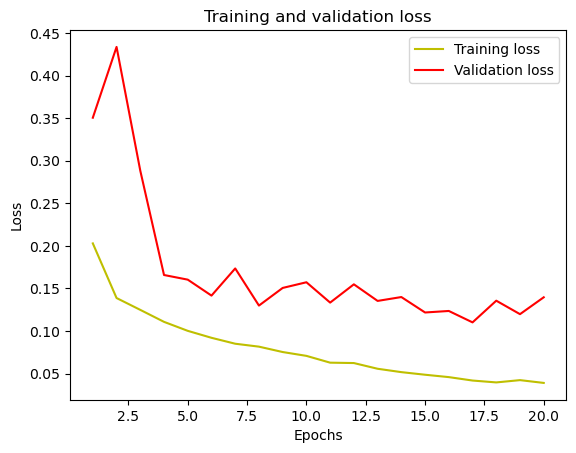

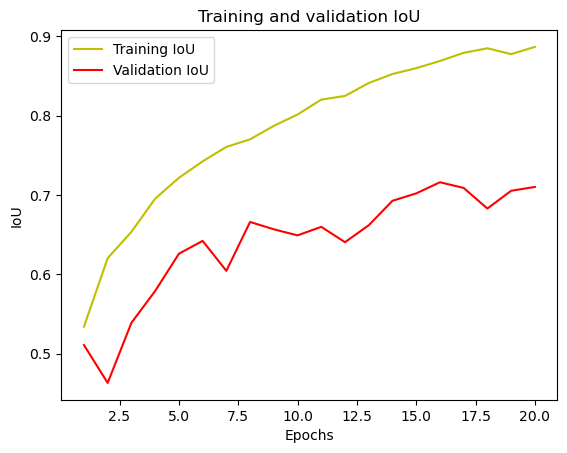

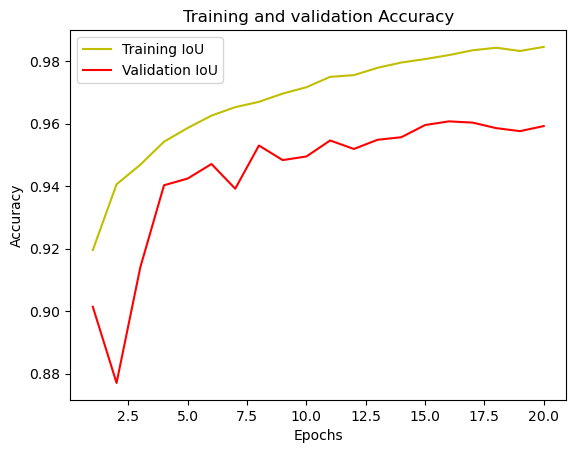

In [33]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction

In [34]:
from keras.models import load_model

model = load_model("saved_model/alltram_960_512_track_batch_10_epoch20.hdf5", compile=False)

# Prediction using indexes

index in tets set:  47
1/1 [==============================] - 1s 1s/step


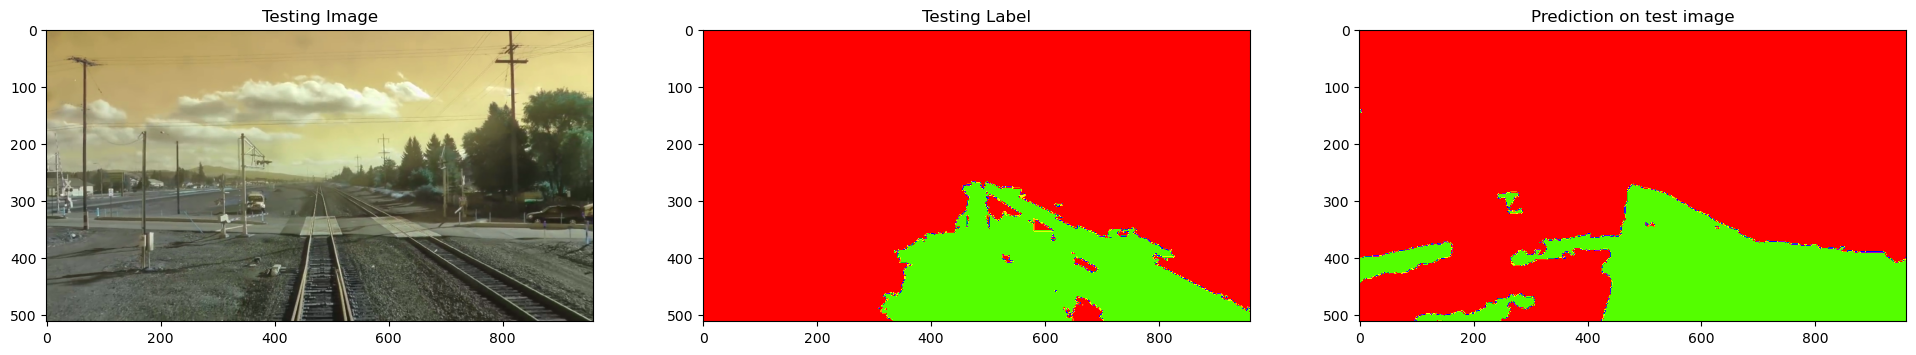

In [35]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  148
1/1 [==============================] - 1s 636ms/step


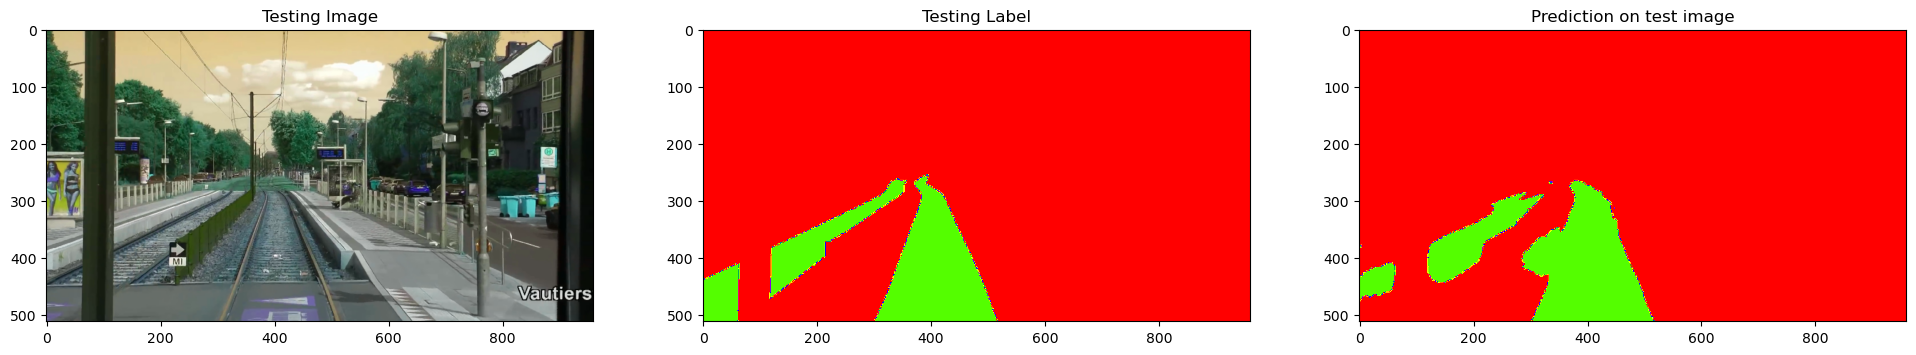

In [37]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  112
1/1 [==============================] - 1s 734ms/step


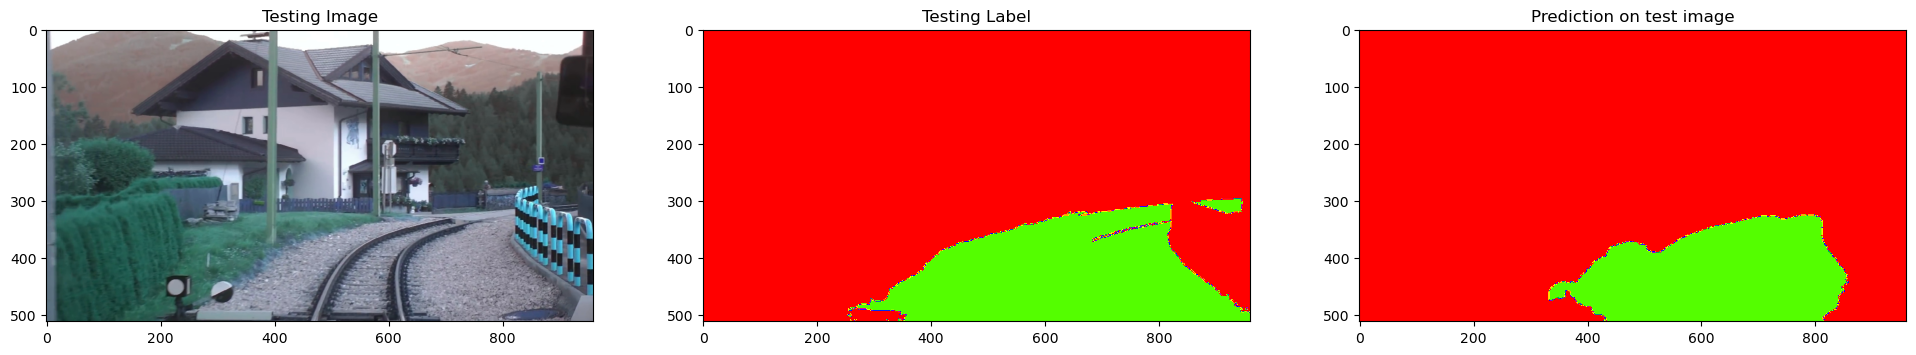

In [38]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  85
1/1 [==============================] - 1s 728ms/step


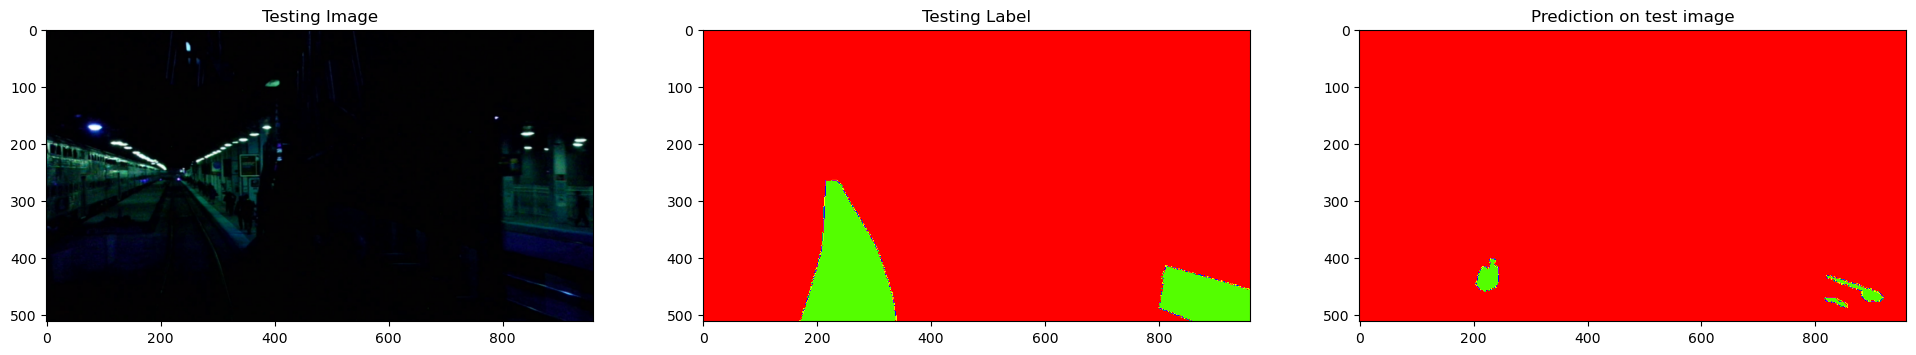

In [39]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  239
1/1 [==============================] - 1s 885ms/step


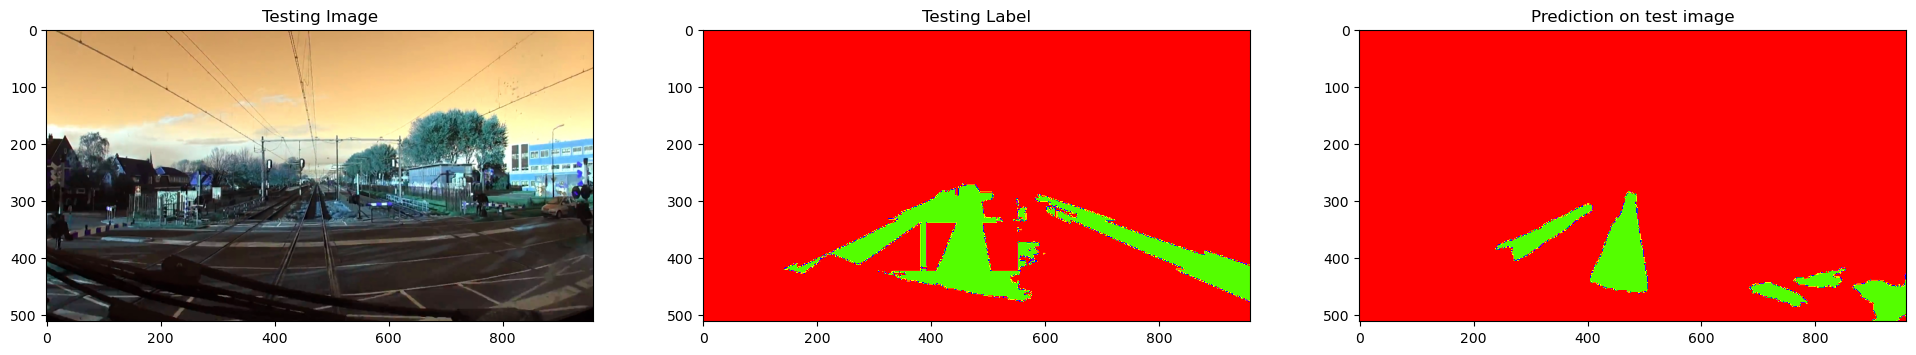

In [40]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  36
1/1 [==============================] - 1s 782ms/step


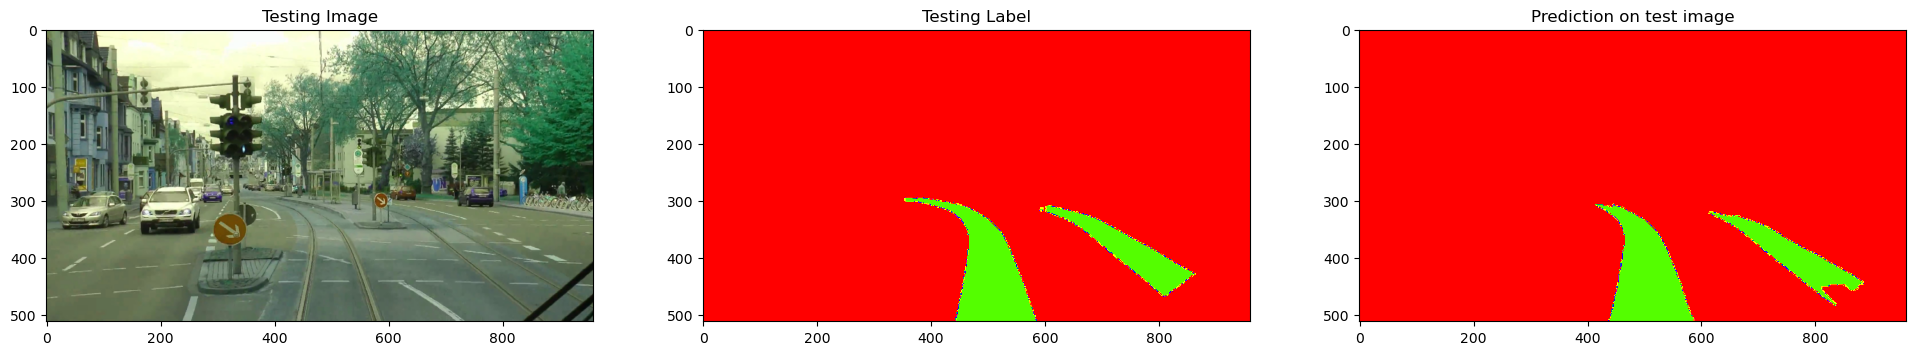

In [41]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  160
1/1 [==============================] - 0s 499ms/step


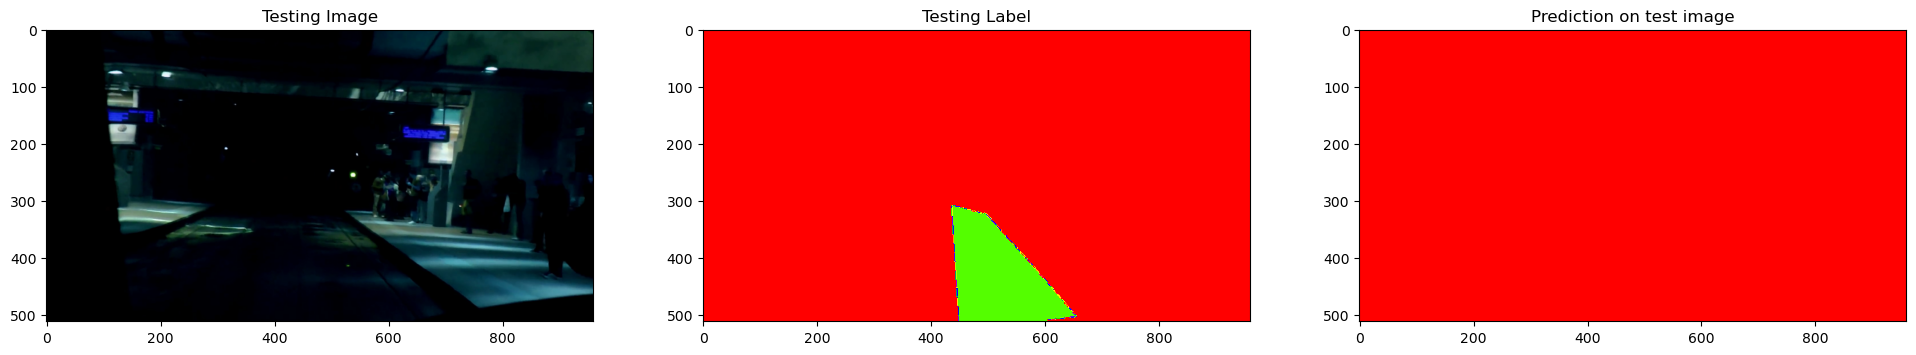

In [42]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  110
1/1 [==============================] - 1s 596ms/step


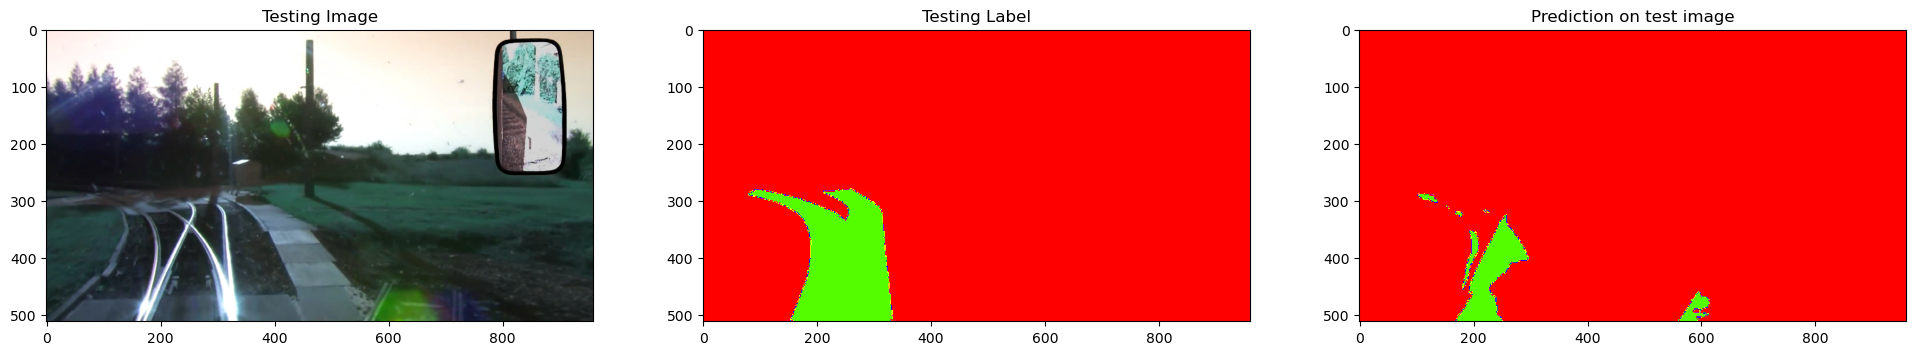

In [43]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  202
1/1 [==============================] - 1s 655ms/step


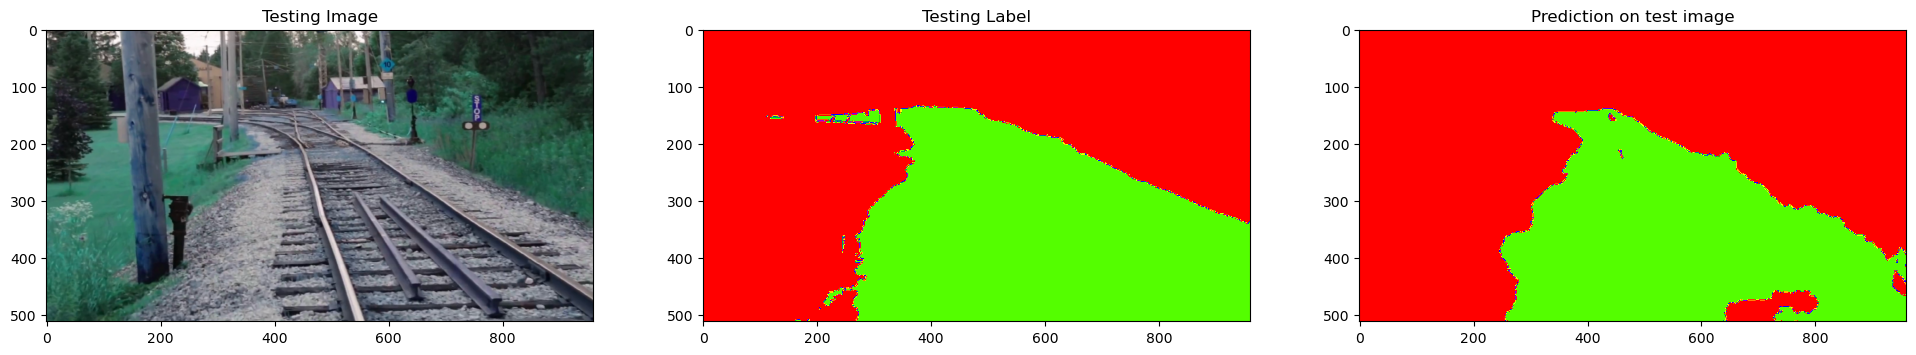

In [44]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  227
1/1 [==============================] - 1s 545ms/step


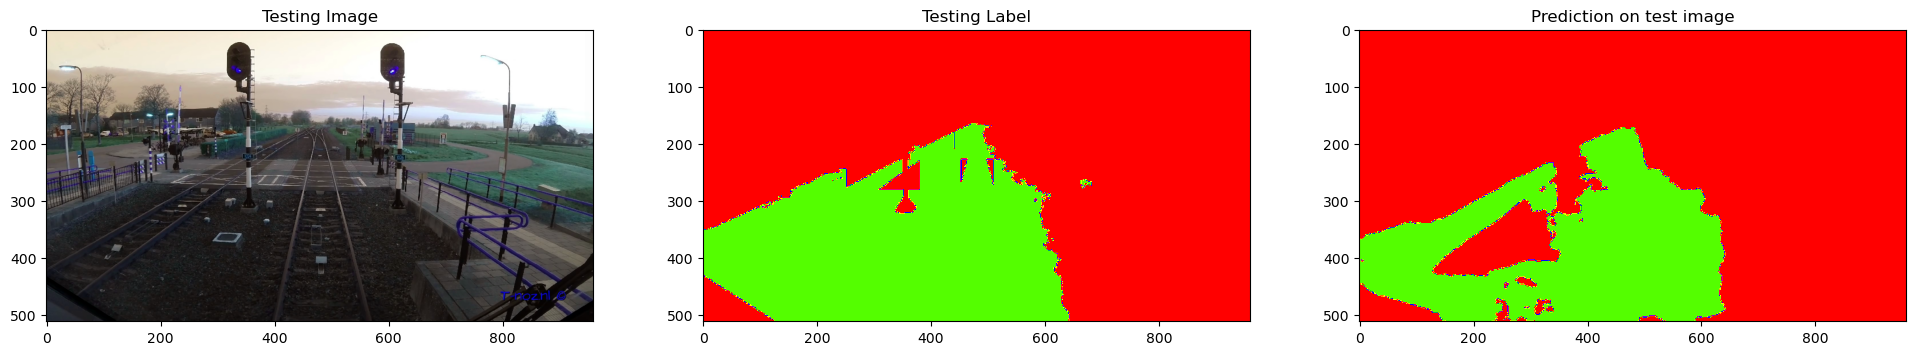

In [45]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  184
1/1 [==============================] - 1s 694ms/step


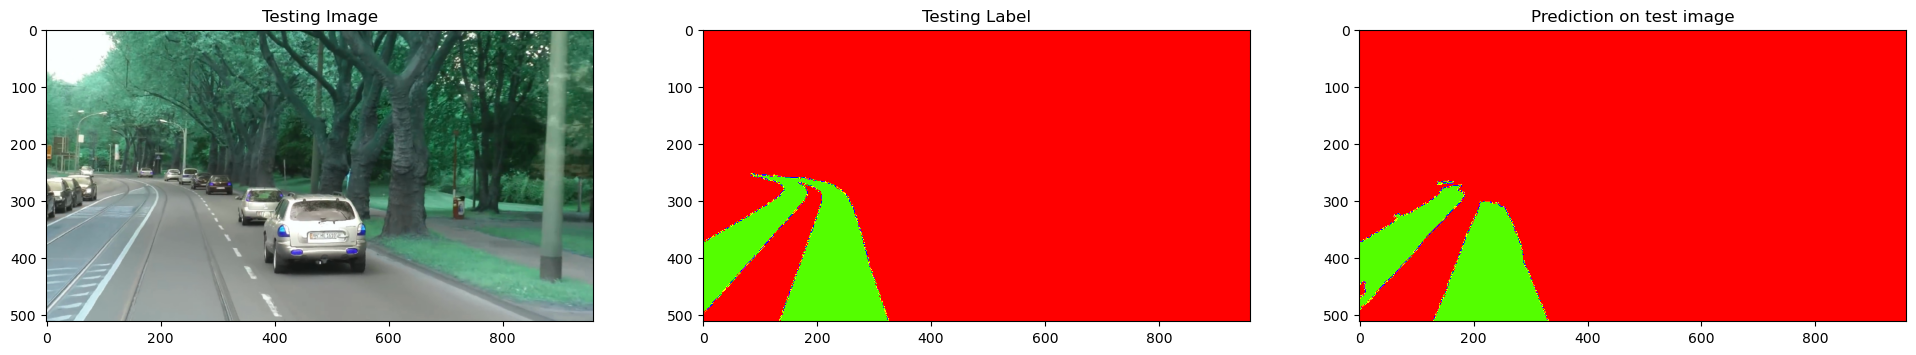

In [46]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  186
1/1 [==============================] - 1s 716ms/step


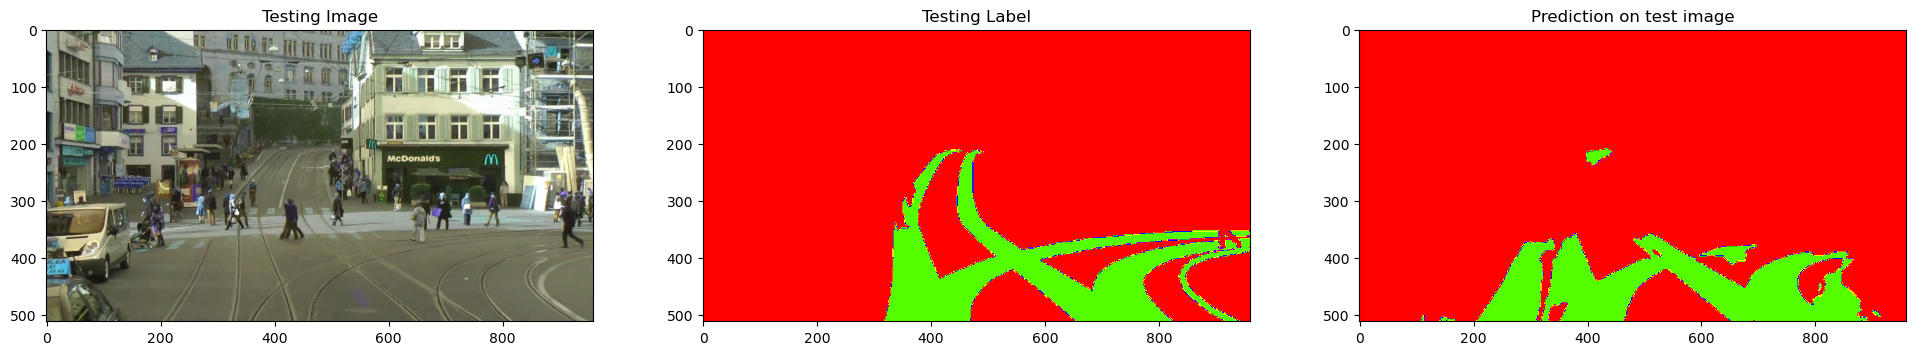

In [47]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  108
1/1 [==============================] - 1s 677ms/step


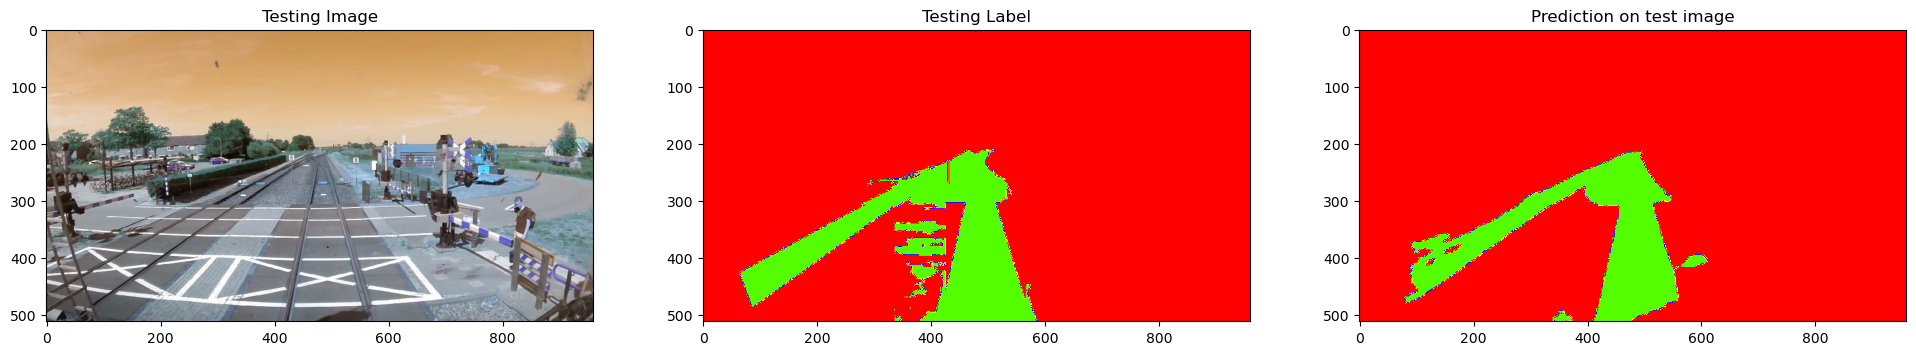

In [49]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [17]:
test_list = ['rs00079','rs01562','rs02536','rs03764','rs04744','rs05410','rs07603','rs08095','rs08443']

index in tets set:  98
1/1 [==============================] - 1s 1s/step


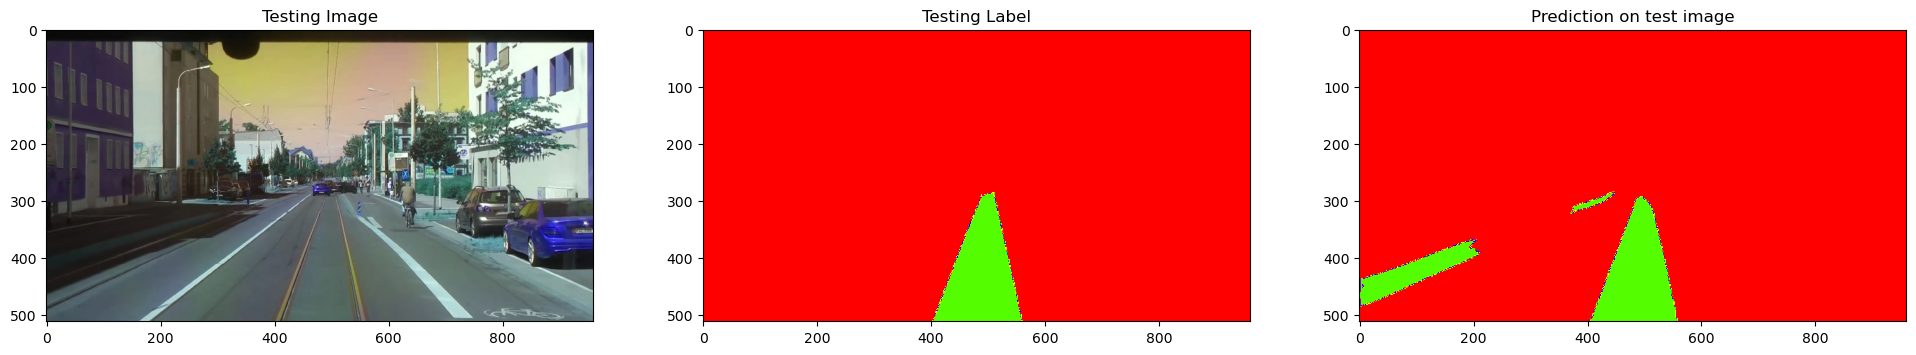

In [18]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  89
1/1 [==============================] - 1s 615ms/step


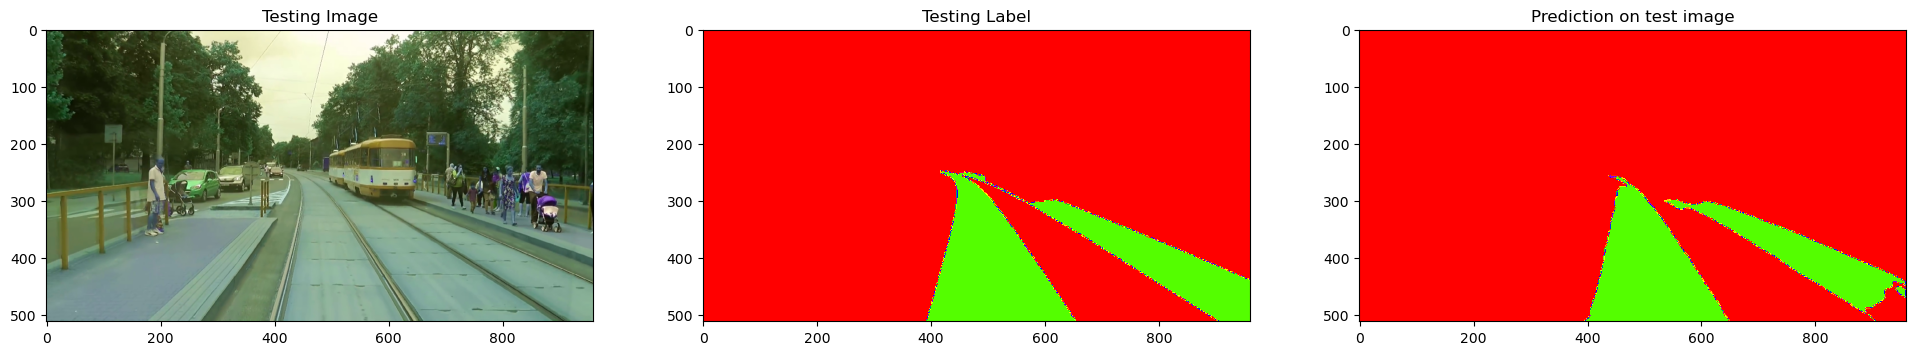

In [19]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  13
1/1 [==============================] - 1s 563ms/step


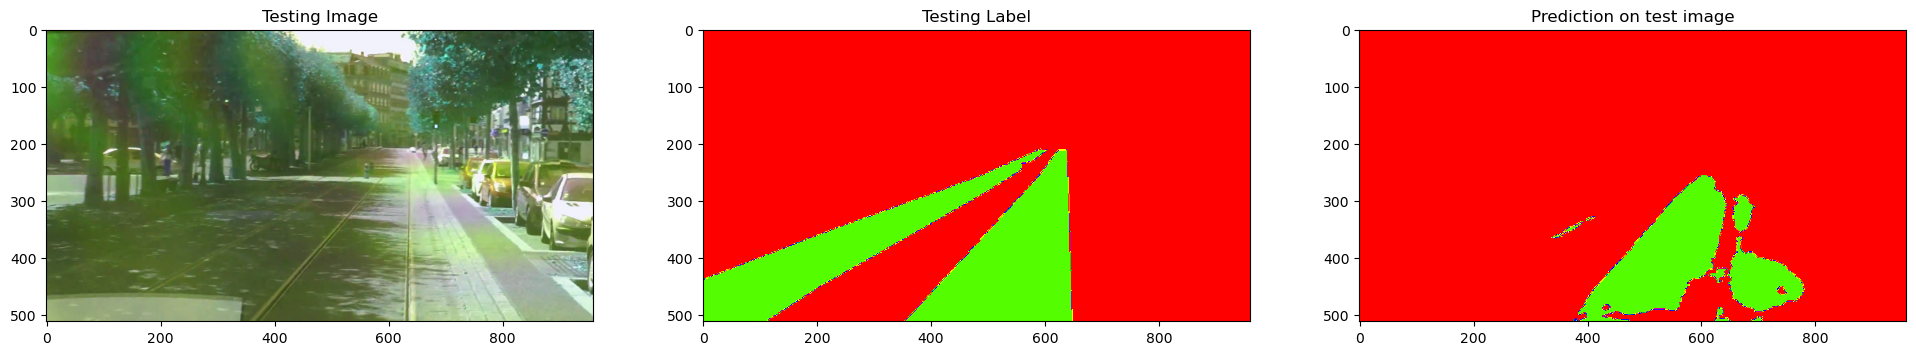

In [20]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  99
1/1 [==============================] - 1s 551ms/step


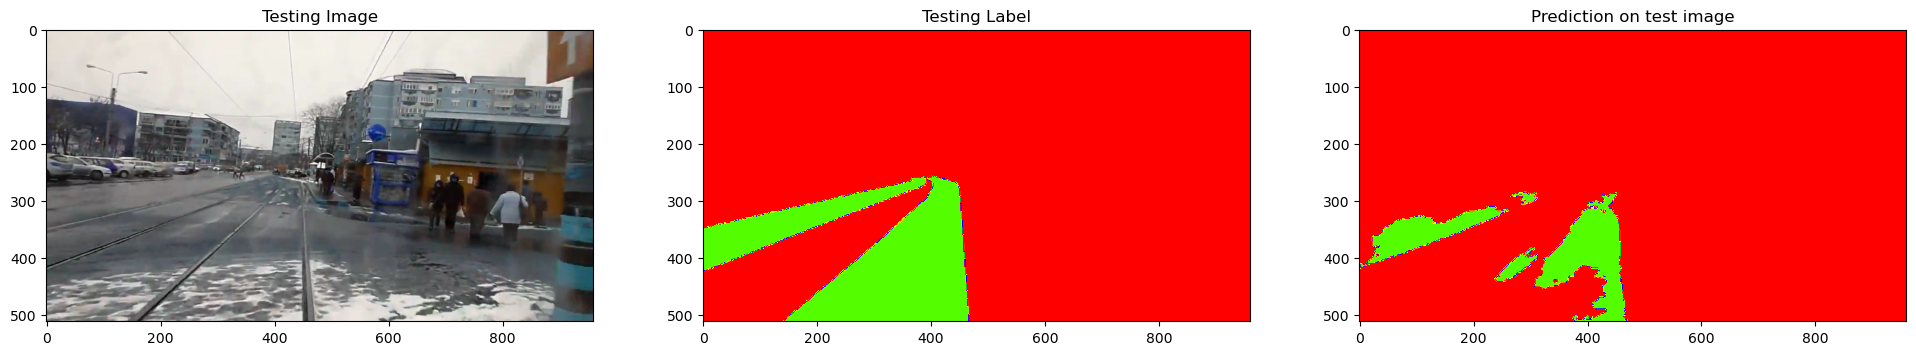

In [21]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  18
1/1 [==============================] - 1s 649ms/step


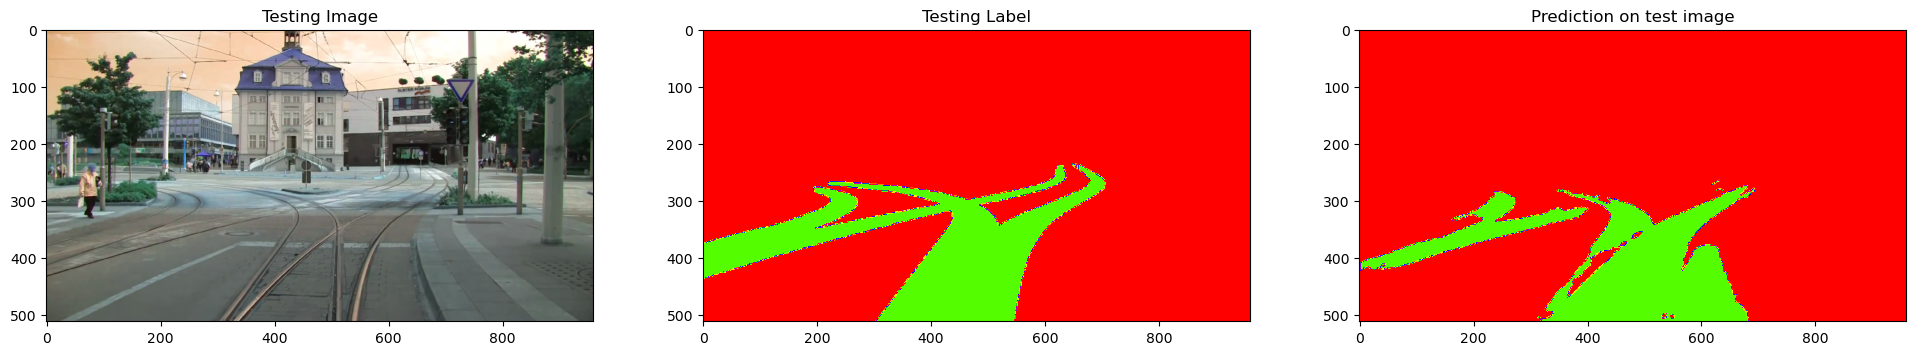

In [22]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  56
1/1 [==============================] - 1s 709ms/step


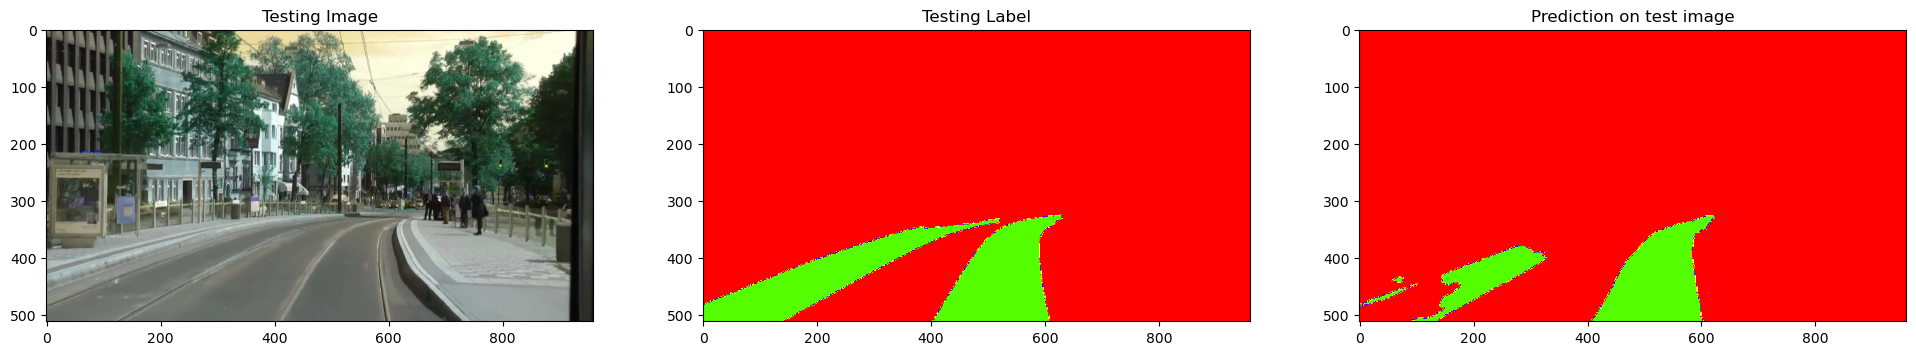

In [23]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  14
1/1 [==============================] - 1s 794ms/step


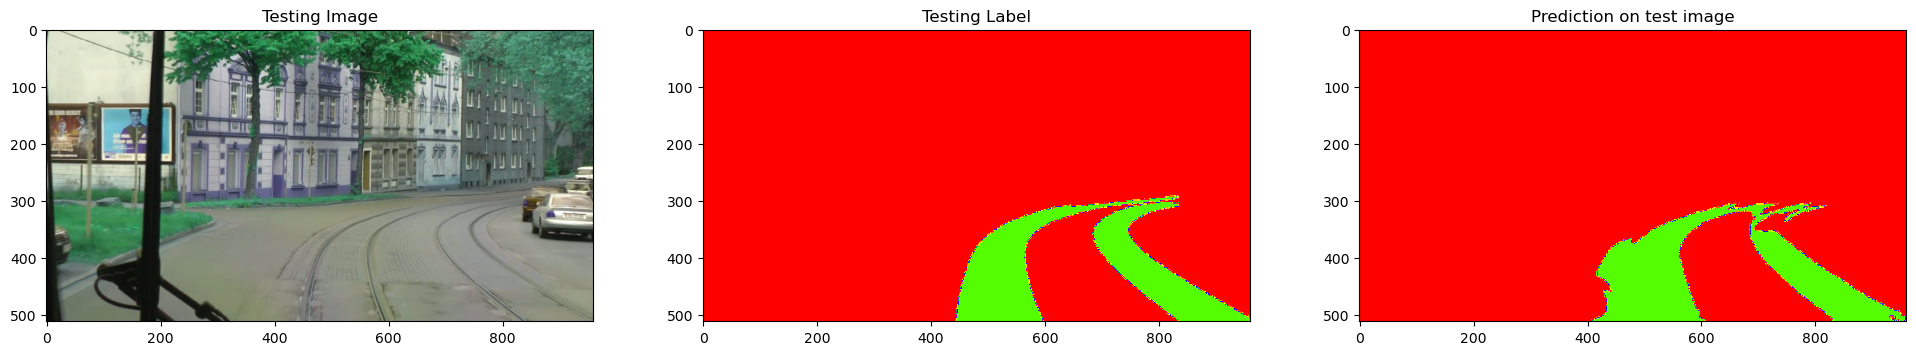

In [24]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  88
1/1 [==============================] - 1s 901ms/step


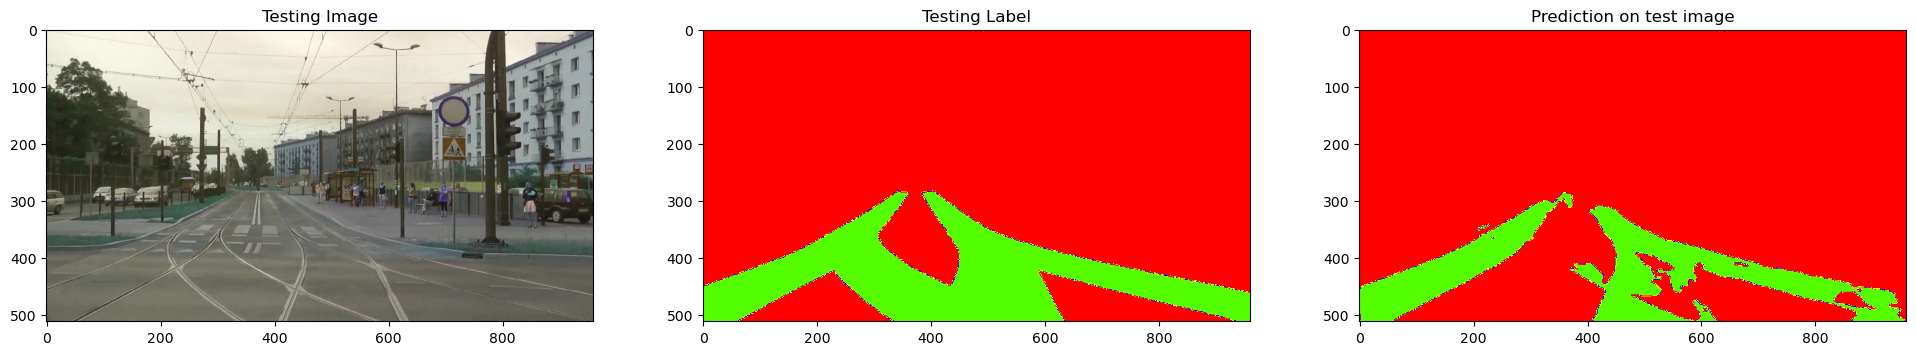

In [25]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  62
1/1 [==============================] - 1s 1s/step


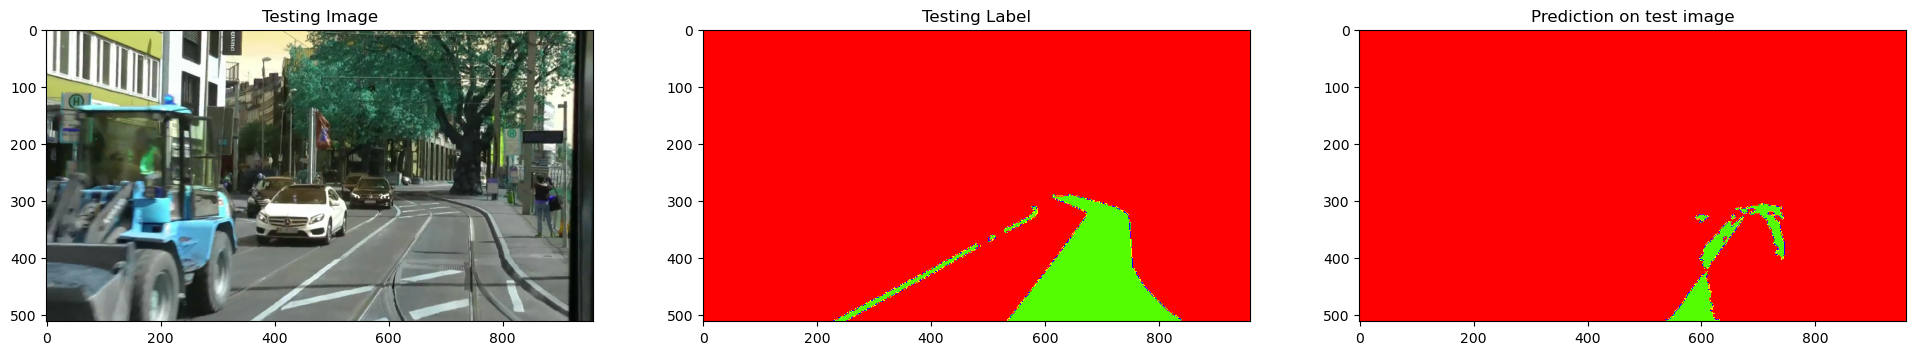

In [26]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  51
1/1 [==============================] - 1s 1s/step


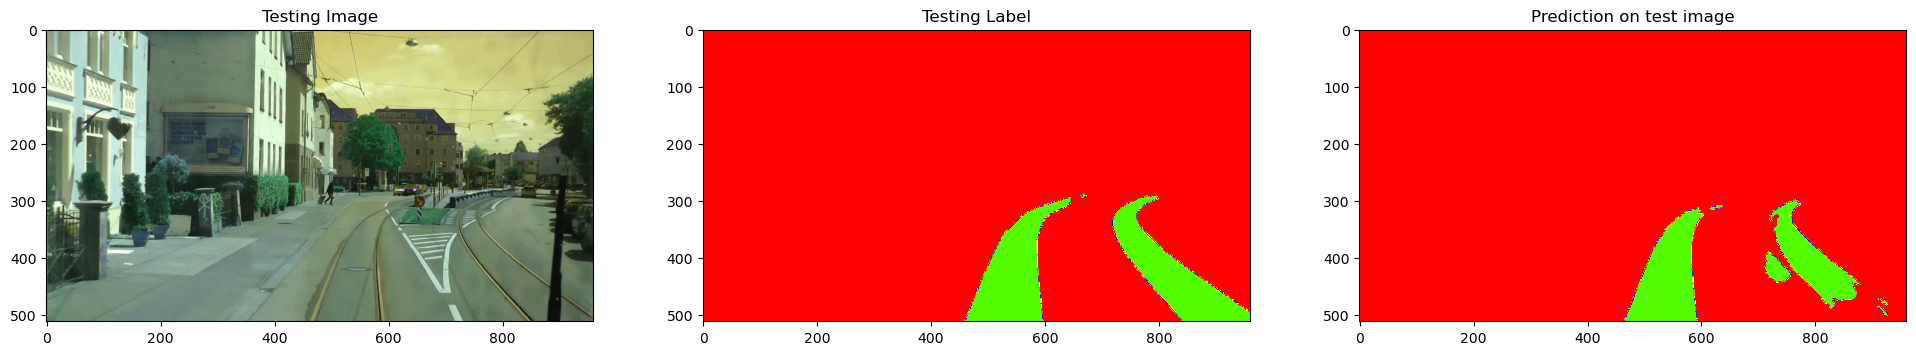

In [27]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

index in tets set:  43
1/1 [==============================] - 1s 909ms/step


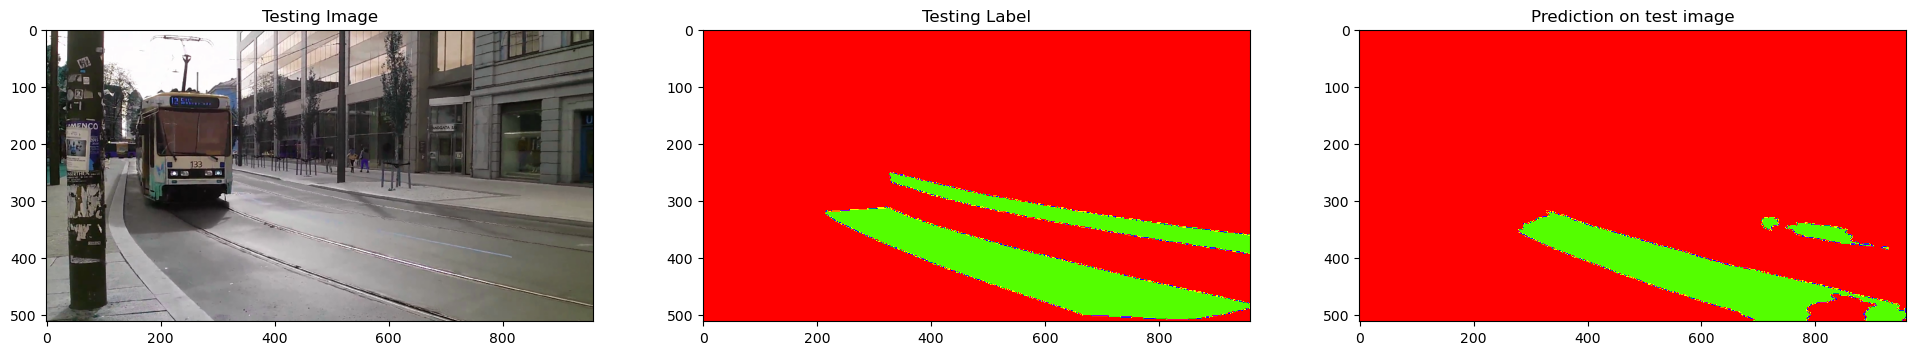

In [28]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
print('index in tets set: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [16]:
for imgfile in range(len(test_list)):
    test_img= cv2.imread(path_images_resized+test_list[imgfile]+'.jpg.jpg',1)
    #print('test_image shape',test_img.shape)
    
    ground_truth= cv2.imread(path_masks_resized+test_list[imgfile]+'.png.png',0)
    #print("ground_truth shape",ground_truth.shape)

    test_img_input=np.expand_dims(test_img, 0) #this is to make (960,512, 1) -> (1, 960, 512, 1)
    #print("ground truth shape expanded", test_img_input.shape)

    prediction = (model.predict(test_img_input))
    #print("Prediction shape",prediction_custom.shape)
    my_threshold = 0.8
    predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
    #print("Prediction_converted_shape",predicted_img_custom.shape)

    plt.figure(figsize=(24, 16))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
    plt.subplot(232)
    plt.title('Testing Label')
    #plt.imshow(ground_truth_custom[:,:,0], cmap='prism')
    plt.imshow(ground_truth[:,:], cmap='prism')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='prism')
    plt.show()

NameError: name 'test_list' is not defined